# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Pilot-Plant-Identification" data-toc-modified-id="Pilot-Plant-Identification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pilot Plant Identification</a></div><div class="lev2 toc-item"><a href="#Nomenclature" data-toc-modified-id="Nomenclature-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Nomenclature</a></div><div class="lev1 toc-item"><a href="#Sensor-Calibration" data-toc-modified-id="Sensor-Calibration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensor Calibration</a></div><div class="lev2 toc-item"><a href="#Calibrate-voltage-output" data-toc-modified-id="Calibrate-voltage-output-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calibrate voltage output</a></div><div class="lev2 toc-item"><a href="#Calibrate-display-value" data-toc-modified-id="Calibrate-display-value-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Calibrate display value</a></div><div class="lev1 toc-item"><a href="#Static-Curve" data-toc-modified-id="Static-Curve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Static Curve</a></div><div class="lev1 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset</a></div><div class="lev2 toc-item"><a href="#Training-Set" data-toc-modified-id="Training-Set-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training Set</a></div><div class="lev3 toc-item"><a href="#Input" data-toc-modified-id="Input-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Input</a></div><div class="lev3 toc-item"><a href="#Output" data-toc-modified-id="Output-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Output</a></div><div class="lev2 toc-item"><a href="#Test-Set" data-toc-modified-id="Test-Set-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test Set</a></div><div class="lev3 toc-item"><a href="#Input" data-toc-modified-id="Input-421"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Input</a></div><div class="lev3 toc-item"><a href="#Output" data-toc-modified-id="Output-422"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Output</a></div><div class="lev1 toc-item"><a href="#Estimate-Parameters" data-toc-modified-id="Estimate-Parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Estimate Parameters</a></div><div class="lev1 toc-item"><a href="#Model-Validation" data-toc-modified-id="Model-Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Validation</a></div><div class="lev2 toc-item"><a href="#Simulated-output-vs-measured-output" data-toc-modified-id="Simulated-output-vs-measured-output-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Simulated output <em>vs</em> measured output</a></div><div class="lev2 toc-item"><a href="#Mean-Square-Error-(MSE)" data-toc-modified-id="Mean-Square-Error-(MSE)-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Mean Square Error (MSE)</a></div><div class="lev1 toc-item"><a href="#Comparing-Methods" data-toc-modified-id="Comparing-Methods-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Comparing Methods</a></div><div class="lev1 toc-item"><a href="#Parallel-Training-Sensitivity-to-Initial-Parameters" data-toc-modified-id="Parallel-Training-Sensitivity-to-Initial-Parameters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Parallel-Training Sensitivity to Initial Parameters</a></div><div class="lev2 toc-item"><a href="#Example-of-unscaled-data" data-toc-modified-id="Example-of-unscaled-data-81"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Example of unscaled data</a></div>

# Pilot Plant Identification

This Jupyter Notebook contains code used to generate the results described in Example 1 from the paper:

    "Parallel Training Considered Harmful?" Comparing Series-Parallel and Parallel Feedforward Network Training

For this example *LabVolt Level Process Station* model *3503-MO* was used. This plant contains a tank containing water. The water column height $y$ is indirectly measured using a pressure sensor at the bottom of the tank. A pump directs the water from a reservoir into the cylinder at fixed speed, while the flow is regulated using a pneumatically operated valve controlled by the voltage $u$.

In [1]:
using Revise
using CSV
using Plots
using Distributions
using ParallelTrainingNN
import DataFrames
using Polynomials
using LaTeXStrings
using ProgressMeter
using StatPlots

show_PΘ = false

# Plot backend
pyplot();

# Fonts
labelfont = Plots.font("Helvetica", 20);
tickfont =  Plots.font("Helvetica", 15);

  likely near In[1]:3
  likely near In[1]:3


## Nomenclature
Along the code the nomenclature NOE (nonlinear output error) and NARX (nonlinar autoregressive with exogenous input)
will sometimes be used to refer to the models obtained through parallel and series-parallel training, respectively.

# Sensor Calibration

A set of points containing the column height (in mm), the sensor voltage output (in Volts) and the pressure presented in the sensor display (in mmH2O) is loaded and used to find a linear relation that can be used to convert the measured output values to a unit system of interest.


In [2]:
# Get points
df = CSV.read("calibration_data/calibration_data.csv")
measured_values, displayed_values, voltage = Vector(df[:measured_values]), Vector(df[:displayed_values]), Vector(df[:voltage]);

## Calibrate voltage output
The pressure sensor produces a voltage output that is linearly related with the water column height. A first order polynomial is adjusted to the set of calibration points, giving a relation between the measured output (in Volts) and the water column height (in mm) .


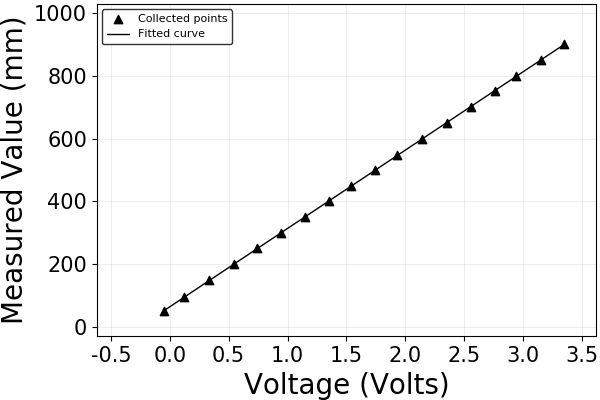

/Users/antonio/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [3]:
# Plot measured value vs voltage
scatter(voltage, measured_values,
        color="black",
        xlims=[-0.5, 3.5],
        ylims=[0, 1000],
        marker=(:utriangle, 6),
        xguide=string("Voltage (Volts)"),
        yguide=string("Measured Value (mm)"),
        xguidefont=labelfont, 
        yguidefont=labelfont,
        xtickfont=tickfont,
        ytickfont=tickfont,
        xticks=-0.5:0.5:3.5,
        yticks=0:200:1000,
        label="Collected points",
        legend=:topleft)
# Adjust linear curve to points
poly_voltage = polyfit(voltage, measured_values, 1);
measured_values_fit = polyval(poly_voltage, voltage);
# Plot adjusted curve
plot!(voltage, measured_values_fit,
      color="black",
      label="Fitted curve")

## Calibrate display value
Besides the voltage output, the sensor also displays the pressure in a display. A first order polynomial is adjusted to the set of calibration points, giving a relation between the measured output (in mm) and the value in the display (in mmH2O).


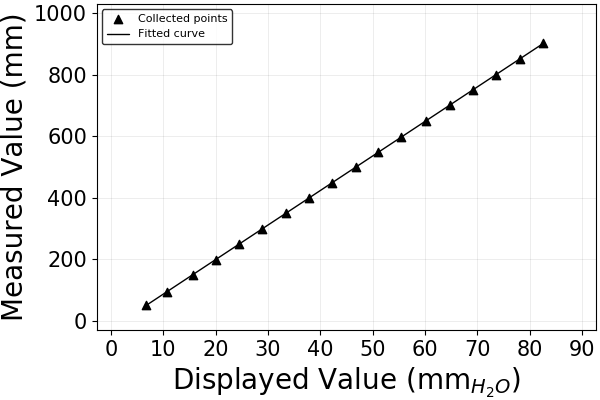

In [4]:
# Plot measured vs displayed value
scatter(displayed_values, measured_values,
        color="black",
        xlims=[0, 90],
        ylims=[0, 1000],
        marker=(:utriangle, 6),
        xguide=string(L"Displayed Value (mm$_{H_2O}$)"),
        yguide=string("Measured Value (mm)"),
        xguidefont=labelfont, 
        yguidefont=labelfont,
        xtickfont=tickfont, 
        ytickfont=tickfont,
        xticks=0:10:90,
        yticks=0:200:1000,
        label="Collected points",
        legend=:topleft)
# Adjust linear curve to points
poly_display = polyfit(displayed_values, measured_values, 1);
measured_values_fit = polyval(poly_display, displayed_values);
# Plot adjusted curve
plot!(displayed_values, measured_values_fit,
      color="black",
      label="Fitted curve")

# Static Curve

The static curve describe the steady state behavior of the system. This curve is obtained by applying constant inputs and annotating the correspondent steady state output, for a sequence of growing input values. This kind of analysis allows us to visualize the kind of nonlinearity the system presents.

**OBS:** This analysis was omitted from the original paper.


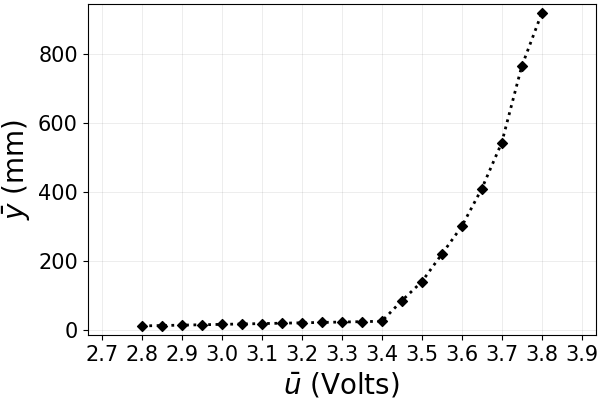

In [5]:
# Load file
df = CSV.read("raw_data/static_curve.csv");
ubar, ybar = Vector(df[:ubar]), Vector(df[:ybar]);
# Apply the linear relation found at sensor calibration, to convert y to millimeters.
ybar = polyval(poly_display, ybar);
# Save static curve points after calibration
df_new = DataFrames.DataFrame(ubar=ubar, ybar=ybar);
CSV.write("processed_data/static_curve.csv", df_new);
# Plot
plot(ubar, ybar,
     color="black",
     xlims=[2.7, 3.9],
     marker=(:d, 5),
     line=(:dot, 2),
     xguide=string(L"$\bar{u}$ (Volts)"),
     yguide=string(L"$\bar{y}$ (mm)"),
     xguidefont=labelfont, 
     yguidefont=labelfont,
     xtickfont=tickfont, 
     ytickfont=tickfont,
     xticks=2.7:0.1:3.9,
     legend=false)

# Dataset

## Training Set
Two hours of recorded data will be used to train the neural network model. This data will be loaded, decimated, adjusted according to the linear relation found at calibration and stored in an appropriated data structure.


In [6]:
# Get Data from file
df = CSV.read("raw_data/training_set.csv");
ti, ui, yi = Vector(df[:time]), Vector(df[:input]), Vector(df[:output]);
# Decimate data by a factor of 10
ti = ti[1:10:end]
ui = ui[1:10:end]
yi = yi[1:10:end]
# Apply calibration relation
yi = polyval(poly_voltage, yi)
# Save training set after calibration and decimation
df_new = DataFrames.DataFrame(time=ti, input=ui, output=yi);
CSV.write("processed_data/training_set.csv", df_new);
# Get sample time
Ts = ti[2] - ti[1];
# Create data structure
annotation = string("This data was collected from LabVolt Level Process Station model 3503-MO.",
                    "This plant contains a tank containing water, for which the water column height ",
                    "y is indirectly measured using a pressure sensor at the bottom of the tank. ",
                    "A pump directs the water from a reservoir into the tank at fixed speed, while ",
                    "the flow is regulated using a pneumatically operated valve controlled by the voltage u.")
identification_data = IdData(yi, ui, Ts;
                             input_unit="Volts", output_unit="mm",
                             time_unit="seconds", annotation=annotation);

### Input
Display the input applied to the system (training set).


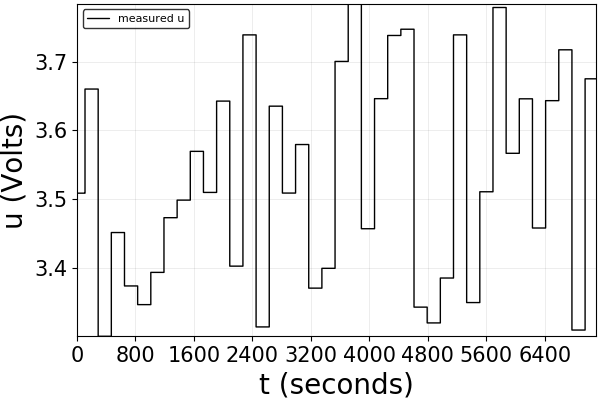

In [7]:
# Plot input vector
plot_input(identification_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont,
           xticks=0:800:7200)

### Output

Display the system output (training set).


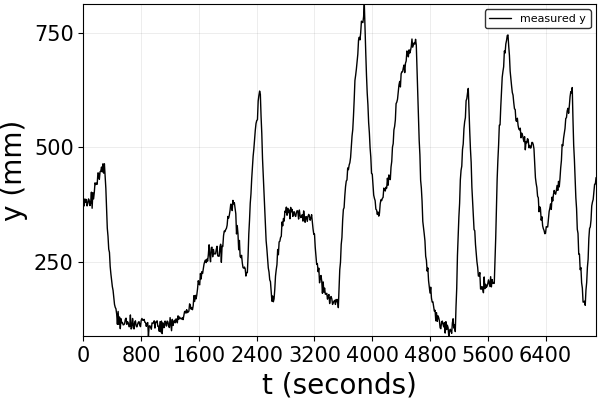

In [8]:
# Plot output vector
plot_output(identification_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont,
           xticks=0:800:7200)

## Test Set
One hours of recorded data will be used to validate the neural network model. This data will be loaded, decimated, adjusted according to the linear relation found at calibration and stored in an appropriated data structure.

In [9]:
# Get Data from file
df = CSV.read("raw_data/test_set.csv");
tv, uv, yv = Vector(df[:time]), Vector(df[:input]), Vector(df[:output]);
# Decimate data by a factor of 10
tv = tv[1:10:end]
uv = uv[1:10:end]
yv = yv[1:10:end]
# Apply calibration relation
yv = polyval(poly_voltage, yv)
# Save training set after calibration and decimation
df_new = DataFrames.DataFrame(time=tv, input=uv, output=yv);
CSV.write("processed_data/test_set.csv", df_new);
# Get sample time
Ts = tv[2] - tv[1];
# Create data structure
annotation = string("This data was collected from LabVolt Level Process Station model 3503-MO.",
                    "This plant contains a tank containing water, for which the water column height ",
                    "y is indirectly measured using a pressure sensor at the bottom of the tank. ",
                    "A pump directs the water from a reservoir into the tank at fixed speed, while ",
                    "the flow is regulated using a pneumatically operated valve controlled by the voltage u.")
validation_data = IdData(yv, uv, Ts;
                         input_unit="Volts", output_unit="mm",
                         time_unit="seconds", annotation=annotation);

### Input
Display the input applied to the system (training set).


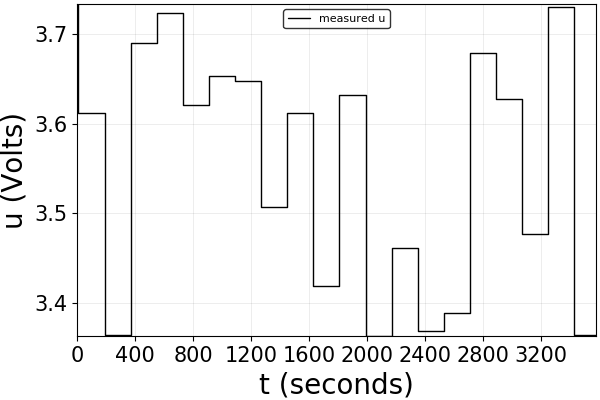

In [10]:
# Plot input vector
plot_input(validation_data,
           xguidefont=labelfont, 
           yguidefont=labelfont,
           xtickfont=tickfont,
           ytickfont=tickfont,
           xticks=0:400:3400)

### Output

Display the system output (training set).


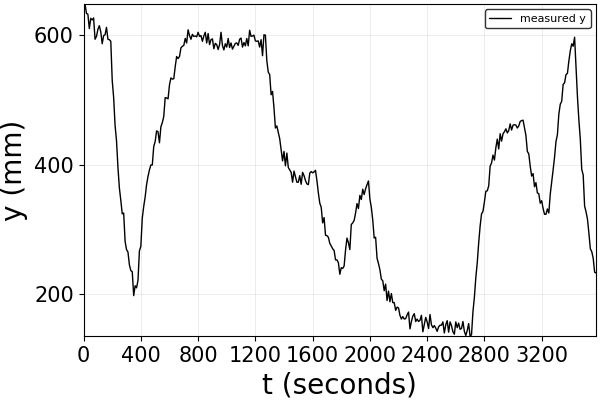

In [11]:
# Plot output vector
plot_output(validation_data,
            xguidefont=labelfont, 
            yguidefont=labelfont,
            xtickfont=tickfont,
            ytickfont=tickfont,
            xticks=0:400:3400)

# <a name="estimate_parameters"></a>Estimate Parameters

A first order model $y[k] = F(y[k-1], u[k-1]; \mathbf{\Theta})$ is adjusted to the training set. Where $F(\bullet; \mathbf{\Theta})$ is a feedforward neural network containing a single hidden layer with 10 nodes

In [12]:
# Define Static Model
mdl = FeedforwardNetwork(2, 1, [10])
# Define Dynamic Terms
yterms = [[1]];
uterms = [[1]];
# Learn Normalization
mdl = learn_normalization(mdl, yterms, uterms, identification_data);
# Call function first time in order to not include first time execution overhead
# in the computed run time.
narx(mdl, yterms, uterms, identification_data);
# Estimate parameters
seed = 62;
print("SP:");
srand(seed);
@time dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
print("PΘ:");
srand(seed);
@time dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
print("PΦ:");
srand(seed);
@time dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);

SP:  4.976288 seconds (12.52 M allocations: 619.104 MiB, 7.27% gc time)
PΘ:  6.044342 seconds (13.57 M allocations: 736.704 MiB, 10.95% gc time)
PΦ:  8.849496 seconds (13.73 M allocations: 732.428 MiB, 5.56% gc time)


# Model Validation

The estimated model will be validated on the test set in order to get an estimation of the prediction error in a fresh set of data. The
free-run simulation of models obtained by both training methods will be compared on the validation set.

In [13]:
# Define free_run_simulation structure
freerun = free_run_simulation(mdl, yterms, uterms, validation_data);

## Simulated output *vs* measured output
The plots shows the free-run simulation of both models in the test set.


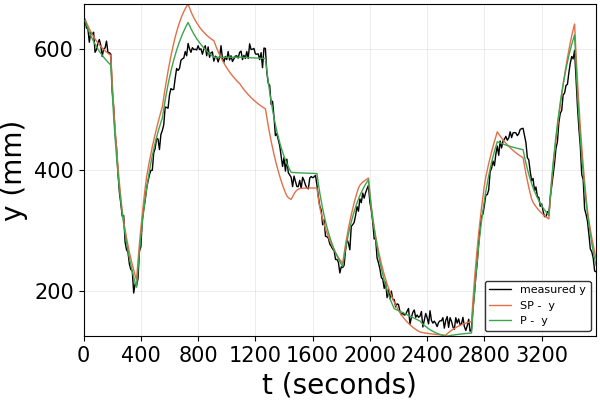

In [14]:
# Plot output vector
if show_PΘ
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΘ, dynfit_PΦ], label=["SP - ", "PΘ - ", "PΦ - "],
                color=[:green, :red, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont,
                xticks=0:400:3400)
else
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΦ], label=["SP - ", "P - "],
                color=[:green, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont,
                xticks=0:400:3400)
end

## Mean Square Error (MSE)
The mean square error of NARX and NOE models on the test set is computed next.

In [15]:
# Free-run simulation
ts = get_slice(freerun, get_time_vector(validation_data));
us = get_slice(freerun, validation_data.u);
ys = get_slice(freerun, validation_data.y);
ys_SP = predict(freerun, dynfit_SP);
ys_PΘ = predict(freerun, dynfit_PΘ);
ys_PΦ = predict(freerun, dynfit_PΦ);
# Save validation results
df_new = DataFrames.DataFrame(time=vec(ts), input=vec(us), output=vec(ys),
                   SP_simulation=vec(ys_SP), PPhi_simulation=vec(ys_PΦ), PTheta_simulation=vec(ys_PΘ));
CSV.write("validation_results.csv", df_new);
# Compute error
e_SP = ys - ys_SP;
e_PΘ = ys - ys_PΘ;
e_PΦ = ys - ys_PΦ;
# Compute MSE
println(string("MSE SP = ", mean(e_SP.^2)))
if show_PΘ
    println(string("MSE PΘ = ", mean(e_PΘ.^2)))
    println(string("MSE PΦ = ", mean(e_PΦ.^2)))
else
    println(string("MSE P = ", mean(e_PΦ.^2)))
end

MSE SP = 1144.5768902660682
MSE P = 296.21633078609034


# Comparing Methods

The weights of the neural network are initialized randomly, and for different number generator seeds different values of MSE are attained.  A more meaningful way to compare the two training method would be to compare several realizations of the same experiment for different initial random seeds.

The following code compute the MSE for 100 examples and check for how many times the parallel training is worse than series-parallel training model and the best case MSE for each one of the training modes.

In [16]:
n = 100
MSE_SP = Array{Float64}(n)
MSE_PΘ = Array{Float64}(n)
MSE_PΦ = Array{Float64}(n)
@showprogress 1 "Computing..." for i = 1:n
    # Estimate narx and noe models model
    seed = i
    srand(seed);
    dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
    srand(seed);
    dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
    srand(seed);
    dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
    ys_SP = predict(freerun, dynfit_SP);
    ys_PΘ = predict(freerun, dynfit_PΘ);
    ys_PΦ = predict(freerun, dynfit_PΦ);
    e_SP = ys - ys_SP;
    e_PΘ = ys - ys_PΘ;
    e_PΦ = ys - ys_PΦ;
    # Compute MSE
    MSE_SP[i] = mean(e_SP.^2)
    MSE_PΘ[i] = mean(e_PΘ.^2)
    MSE_PΦ[i] = mean(e_PΦ.^2)
end

Computing...100%|███████████████████████████████████████| Time: 0:22:51


In [17]:
println("Parallel training is worse than series-parallel training only ", sum(MSE_SP .< MSE_PΦ), " out of ", n)
println("Series-parallel min MSE = ", minimum(MSE_SP), ", Parallel min MSE = ", minimum(MSE_PΦ))

Parallel training is worse than series-parallel training only 21 out of 100
Series-parallel min MSE = 356.


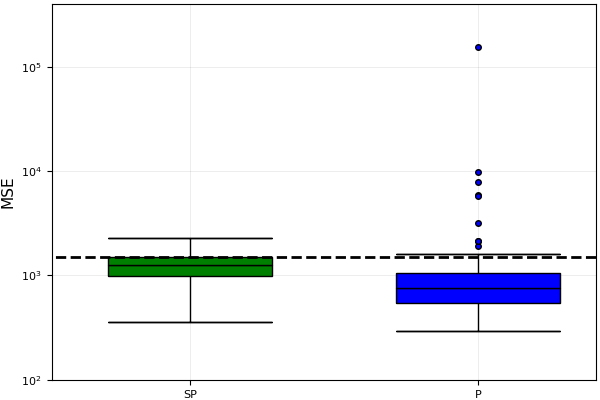

In [22]:
if show_PΘ
    p = plot(xticks=([0.5, 1.9, 3.3], ["SP", "PΘ", "PΦ"]), grid=true, xlims=[-0.2, 2.5])
    boxplot!(p, ["SP"], [MSE_SP], yscale=:log10, ylims=(10^2, 4*10^5), ylabel="MSE", color=:green, legend=false)
    boxplot!(p, ["PΘ"], [MSE_PΘ], color=:red)
    boxplot!(p, ["PΦ"], [MSE_PΦ], color=:blue)
else
    p = plot(xticks=([0.5, 1.9], ["SP", "P"]), grid=true, xlims=[-0.1, 2.4])
    boxplot!(p, ["SP"], [MSE_SP], yscale=:log10, ylims=(10^2, 4*10^5), ylabel="MSE", color=:green, legend=false)
    boxplot!(p, ["P"], [MSE_PΦ], color=:blue)
    # MSE = 1489.5 for ARX model (look at the matlab script)
    plot!(p, 0.-0.3:0.1:2.5, 1489.5*ones(length(-0.3:0.1:2.5)), color=:black, lw=2, s=:dash)
end
savefig(p, "boxplots.tex")
p

The result indicates that, for this example, the NOE model is in general better (considering the mean square test error) than the correspondent (initialized with the same parameters) NARX model. Furthermore, the best NOE model has a smaller validation error than the best NARX model.

# Parallel-Training Sensitivity to Initial Parameters

The series parallel training is more sensitive to the initial parameters choice. For some initial parameter guesses it can converge to a really poor local minima while for the same initial parameter guess the series-parallel training will converge for a reasonably good set of parameters. This is not really a problem since this does not happens often. The number of times parallel training converges to a really poor minima is displayed next.

In [19]:
println("Parallel training converges to a poor local minima (MSE > 5000) ", sum(5000 .< MSE_PΦ), " out of ", n)
println("Series-parallel training converges to a poor local minima (MSE > 5000) ", sum(5000 .< MSE_SP), " out of ", n)

Parallel training converges to a poor local minima (MSE > 5000) 5 out of 100
Series-parallel training converges to a poor local minima (MSE > 5000) 0 out of 100


In other words, considering the random initialization of parameters, the parallel training is (for this example) generally better than series-parallel training. Nevertheless, the parallel training is much more likely to provide very bad models.

## Example of unscaled data
Furthermore, parallel training require some extra precautions to be taken. If the initial parameters distributions or the data are not well scaled it is very likely that the training will not converge to an appropriate minima.

The next example shows what happens if we use ``learn_offset`` instead of ``learn_normalization`` (that is, we only remove offset from the data, but does not normalize it): showing that series-parallel training yields a reasonable model, while parallel training converges to a really ``poor`` local minima.

NARX:  4.409196 seconds (11.40 M allocations: 568.970 MiB, 7.71% gc time)
PΘ:  5.292843 seconds (11.96 M allocations: 652.355 MiB, 7.14% gc time)
PΦ:  5.080358 seconds (11.46 M allocations: 618.516 MiB, 7.30% gc time)



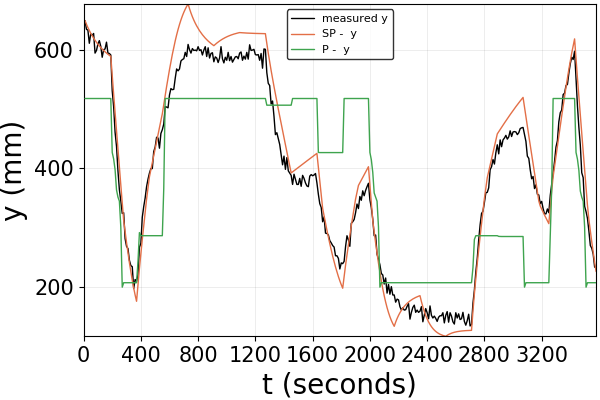

In [20]:
# Define Static Model
mdl = FeedforwardNetwork(2, 1, [10])
# Define Dynamic Terms
yterms = [[1]];
uterms = [[1]];
# Learn Normalization
mdl = learn_offset(mdl, yterms, uterms, identification_data);
# Estimate narx and noe models model
seed = 62;
# Estimate parameters
print("NARX:");
srand(seed);
@time dynfit_SP, opt_SP, e_SP = narx(mdl, yterms, uterms, identification_data);
print("PΘ:");
srand(seed);
@time dynfit_PΘ, opt_PΘ, e_PΘ = noe(mdl, yterms, uterms, identification_data, use_extended=false);
print("PΦ:");
srand(seed);
@time dynfit_PΦ, opt_PΦ, e_PΦ = noe(mdl, yterms, uterms, identification_data, use_extended=true);
# Define free_run_simulation structure
freerun = free_run_simulation(mdl, yterms, uterms, validation_data);
# Plot output vector
if show_PΘ
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΘ, dynfit_PΦ], label=["SP - ", "PΘ - ", "PΦ - "],
                color=[:green, :red, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont,
                xticks=0:400:3400)
else
    plot_output(validation_data, freerun, [dynfit_SP, dynfit_PΦ], label=["SP - ", "P - "],
                color=[:green, :blue],
                xguidefont=labelfont, 
                yguidefont=labelfont,
                xtickfont=tickfont,
                ytickfont=tickfont,
                xticks=0:400:3400)
end

In [21]:
# Free-run simulation
ts = get_slice(freerun, get_time_vector(validation_data));
us = get_slice(freerun, validation_data.u);
ys = get_slice(freerun, validation_data.y);
ys_SP = predict(freerun, dynfit_SP);
ys_PΘ = predict(freerun, dynfit_PΘ);
ys_PΦ = predict(freerun, dynfit_PΦ);
# Save validation results
df_new = DataFrames.DataFrame(time=vec(ts), input=vec(us), output=vec(ys),
                   SP_simulation=vec(ys_SP), PPhi_simulation=vec(ys_PΦ), PTheta_simulation=vec(ys_PΘ));
CSV.write("validation_results.csv", df_new);
# Compute error
e_SP = ys - ys_SP;
e_PΘ = ys - ys_PΘ;
e_PΦ = ys - ys_PΦ;
# Compute MSE
println(string("MSE SP = ", mean(e_SP.^2)))
if show_PΘ
    println(string("MSE PΘ = ", mean(e_PΘ.^2)))
    println(string("MSE PΦ = ", mean(e_PΦ.^2)))
else
    println(string("MSE P = ", mean(e_PΦ.^2)))
end

MSE SP = 983.5021131736448
MSE P = 10972.840008196186
